# 02 - Feature Engineering & Train-Test Split

> Mục tiêu: Tạo thêm các đặc trưng tổ hợp quan trọng, phân tích tương quan, chuẩn bị dữ liệu huấn luyện mô hình.

## 2.1: Import thư viện và đọc dữ liệu đã làm sạch

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv("../data/processed/processed.csv")
df.head()

,gender,age,city,academic_pressure,cgpa,study_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts_?,work/study_hours,financial_stress,family_history_of_mental_illness,depression
0,0,24,49,2.0,5.90,5.0,0,2,3,0,3.0,2.0,1,0
1,1,24,19,3.0,6.10,3.0,0,2,26,1,11.0,1.0,1,1
2,0,19,48,2.0,8.52,4.0,2,0,26,0,6.0,2.0,1,0
3,0,19,43,5.0,5.64,5.0,2,2,26,1,4.0,5.0,1,1
4,0,20,2,5.0,7.25,3.0,0,1,26,1,10.0,3.0,0,1


## 2.2: Tạo đặc trưng tổ hợp mới

In [23]:
# TẠO CÁC ĐẶC TRƯNG TỔNG HỢP MỚI

# Balanced_Life_Score: mô hình hóa sự cân bằng học tập – cuộc sống
df['balanced_life_score'] = (
    df['sleep_duration'] +
    df['study_satisfaction'] -
    df['work/study_hours']
) / 3
# (Total_Stress chưa có nên ta tính nhanh trước)
df['total_stress'] = (
    df['academic_pressure'] +
    df['financial_stress'] +
    df['work/study_hours']
)

# Sleep_Stress_Ratio: tỷ lệ giấc ngủ trên áp lực
df['sleep_stress_ratio'] = df['sleep_duration'] / (df['total_stress'] + 1)

# Multidimensional_Stress: tổng áp lực có trọng số
# Yếu tố	Trọng số	Lý do
# Academic Pressure	0.5	Áp lực học tập là nguồn stress lớn nhất đối với sinh viên
# Financial Stress	0.3	Tiền bạc cũng rất quan trọng nhưng ít hơn học tập
# Work/Study Hours	0.2	Số giờ làm việc ảnh hưởng nhưng chỉ gián tiếp đến stress tổng

df['multidimensional_stress'] = (
    df['academic_pressure'] * 0.5 +
    df['financial_stress'] * 0.3 +
    df['work/study_hours'] * 0.2
)

# Resilience_Index: chỉ số phục hồi tâm lý
df['resilience_index'] = (
    df['cgpa'] + df['study_satisfaction']
) / (1 + df['family_history_of_mental_illness'])

# Suicidal_Risk_Index: nguy cơ suy sụp
# Thành phần	Ý nghĩa	Mục tiêu mô hình hóa
# Academic Pressure * 1.5	Áp lực học tập nhân 1.5 lần	Cường điệu hóa ảnh hưởng của stress học tập
# (10 - Sleep Duration)	Thời lượng thiếu ngủ	Ngủ ít → tăng nguy cơ trầm cảm
# 3 * suicidal thoughts	Có ý định tự tử → nhân trọng số 3	Biến này cực kỳ quan trọng, nhấn mạnh mạnh mẽ
df['suicidal_risk_index'] = (
    df['academic_pressure'] * 1.5 +
    (10 - df['sleep_duration']) +
    3 * df['have_you_ever_had_suicidal_thoughts_?']
)


In [24]:
df.head()

,gender,age,city,academic_pressure,cgpa,study_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts_?,work/study_hours,financial_stress,family_history_of_mental_illness,depression,balanced_life_score,total_stress,sleep_stress_ratio,multidimensional_stress,resilience_index,suicidal_risk_index
0,0,24,49,2.0,5.90,5.0,0,2,3,0,3.0,2.0,1,0,0.666667,7.0,0.000000,2.2,5.45,13.0
1,1,24,19,3.0,6.10,3.0,0,2,26,1,11.0,1.0,1,1,-2.666667,15.0,0.000000,4.0,4.55,17.5
2,0,19,48,2.0,8.52,4.0,2,0,26,0,6.0,2.0,1,0,0.000000,10.0,0.181818,2.8,6.26,11.0
3,0,19,43,5.0,5.64,5.0,2,2,26,1,4.0,5.0,1,1,1.000000,14.0,0.133333,4.8,5.32,18.5
4,0,20,2,5.0,7.25,3.0,0,1,26,1,10.0,3.0,0,1,-2.333333,18.0,0.000000,5.4,10.25,20.5


## 2.3: Phân tích tương quan giữa các đặc trưng

In [25]:
# Xác định các cột ban đầu theo định dạng snake_case
original_cols = [
    'age','gender','city', 'degree',
    'dietary_habits', 'sleep_duration', 'work/study_hours',
    'academic_pressure', 'study_satisfaction', 'financial_stress',
    'have_you_ever_had_suicidal_thoughts_?', 'family_history_of_mental_illness', 'cgpa'
]

# Các đặc trưng mới (cũng phải đúng snake_case như bạn đã tạo trước đó)
new_feature_cols = [
    'balanced_life_score',
    'sleep_stress_ratio',
    'multidimensional_stress',
    'resilience_index',
    'suicidal_risk_index'
]

# Cột nhãn
target_col = ['depression']

# Tạo thứ tự mới
final_column_order = original_cols + new_feature_cols + target_col

# Sắp xếp lại
df = df[final_column_order]

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


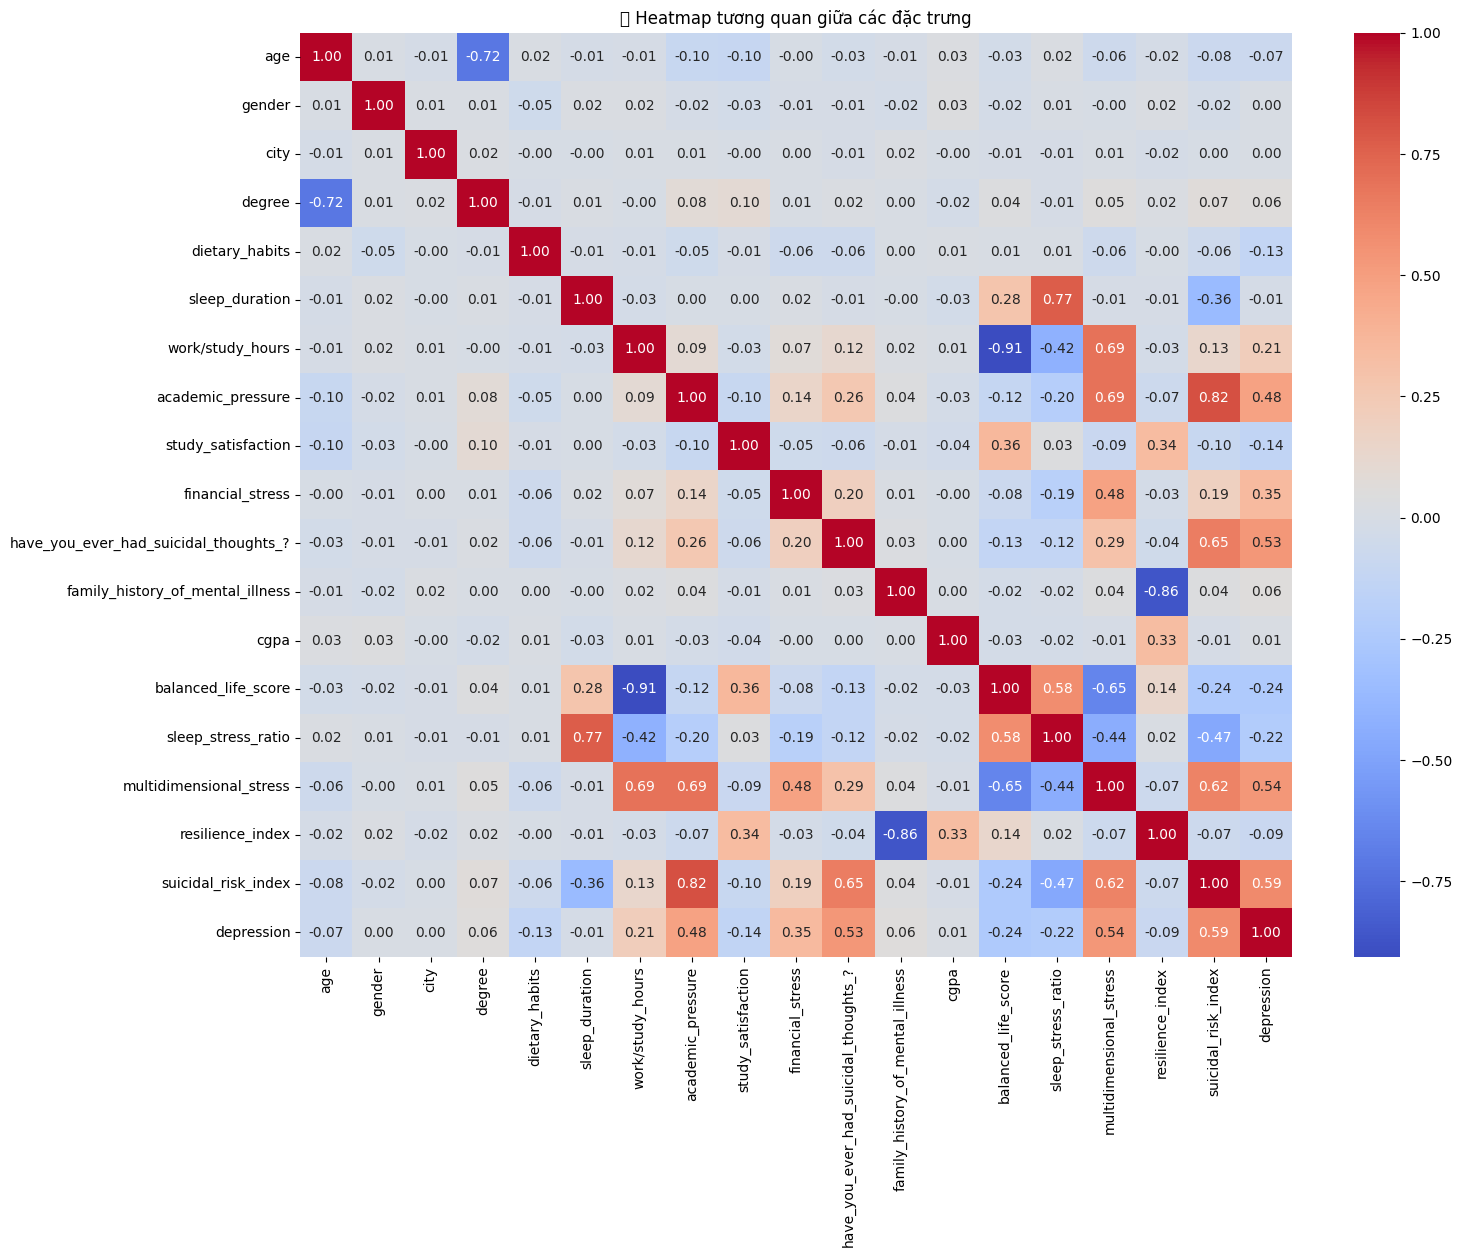

In [26]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("📊 Heatmap tương quan giữa các đặc trưng")
plt.show()

## 2.4: Phân tích phân phối nhãn Depression

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


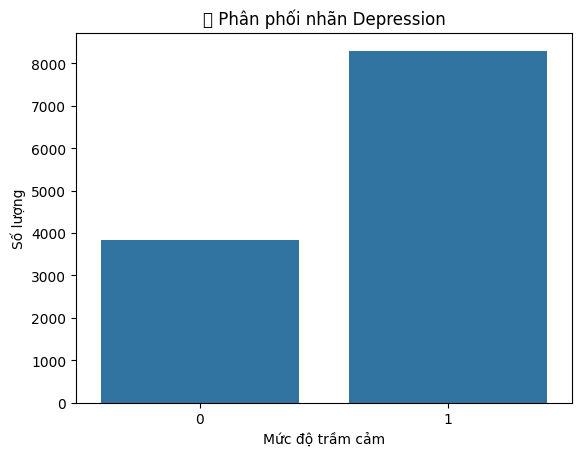

depression
1    8304
0    3836
Name: count, dtype: int64


In [27]:
sns.countplot(x='depression', data=df)
plt.title("📊 Phân phối nhãn Depression")
plt.xlabel("Mức độ trầm cảm")
plt.ylabel("Số lượng")
plt.show()

# In số lượng theo từng lớp
print(df['depression'].value_counts())

In [28]:
# Xác định các cột ban đầu theo định dạng snake_case
original_cols = [
    'age','gender','city', 'degree',
    'dietary_habits', 'sleep_duration', 'work/study_hours',
    'academic_pressure', 'study_satisfaction', 'financial_stress',
    'have_you_ever_had_suicidal_thoughts_?', 'family_history_of_mental_illness', 'cgpa'
]

# Các đặc trưng mới (cũng phải đúng snake_case như bạn đã tạo trước đó)
new_feature_cols = [
    'balanced_life_score',
    'sleep_stress_ratio',
    'multidimensional_stress',
    'resilience_index',
    'suicidal_risk_index'
]

# Cột nhãn
target_col = ['depression']

# Tạo thứ tự mới
final_column_order = original_cols + new_feature_cols + target_col

# Sắp xếp lại
df = df[final_column_order]


## 2.5: Tách tập train/test

In [29]:
# Tách X và y
X = df.drop('depression', axis=1)
y = df['depression']

# Tách 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



## 2.6: Lưu dữ liệu tách sẵn (để các notebook sau dùng lại nhanh)

In [30]:
X_train.to_csv("../data/processed/X_train.csv", index=False)
X_test.to_csv("../data/processed/X_test.csv", index=False)
y_train.to_csv("../data/processed/y_train.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)

print(" Đã lưu X_train, X_test, y_train, y_test vào thư mục /data/")


 Đã lưu X_train, X_test, y_train, y_test vào thư mục /data/


In [31]:
df.head()

,age,gender,city,degree,dietary_habits,sleep_duration,work/study_hours,academic_pressure,study_satisfaction,financial_stress,have_you_ever_had_suicidal_thoughts_?,family_history_of_mental_illness,cgpa,balanced_life_score,sleep_stress_ratio,multidimensional_stress,resilience_index,suicidal_risk_index,depression
0,24,0,49,3,2,0,3.0,2.0,5.0,2.0,0,1,5.90,0.666667,0.000000,2.2,5.45,13.0,0
1,24,1,19,26,2,0,11.0,3.0,3.0,1.0,1,1,6.10,-2.666667,0.000000,4.0,4.55,17.5,1
2,19,0,48,26,0,2,6.0,2.0,4.0,2.0,0,1,8.52,0.000000,0.181818,2.8,6.26,11.0,0
3,19,0,43,26,2,2,4.0,5.0,5.0,5.0,1,1,5.64,1.000000,0.133333,4.8,5.32,18.5,1
4,20,0,2,26,1,0,10.0,5.0,3.0,3.0,1,0,7.25,-2.333333,0.000000,5.4,10.25,20.5,1


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12140 entries, 0 to 12139
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   age                                    12140 non-null  int64  
 1   gender                                 12140 non-null  int64  
 2   city                                   12140 non-null  int64  
 3   degree                                 12140 non-null  int64  
 4   dietary_habits                         12140 non-null  int64  
 5   sleep_duration                         12140 non-null  int64  
 6   work/study_hours                       12140 non-null  float64
 7   academic_pressure                      12140 non-null  float64
 8   study_satisfaction                     12140 non-null  float64
 9   financial_stress                       12140 non-null  float64
 10  have_you_ever_had_suicidal_thoughts_?  12140 non-null  int64  
 11  fa